Please refer to TCR-antigen bi LTSM RNN trained with donor 1 CMV final.ipynb for detailed code explanation.  Most code in this file is copied and reused from the training file.

In [1]:
from __future__ import print_function
import sys
import os
import time

import math
import numpy as np
import tensorflow as tf

###3 blosum related functions downloaded from https://www.biorxiv.org/content/10.1101/433706v1.full

def read_blosum_MN(filename):
    '''
    read in BLOSUM matrix
    parameters:
        - filename : file containing BLOSUM matrix
    returns:
        - blosum : dictionnary AA -> blosum encoding (as list)
    '''

    # read BLOSUM matrix:
    blosumfile = open(filename, "r")
    blosum = {}
    B_idx = 99
    Z_idx = 99
    star_idx = 99

    for l in blosumfile:
        l = l.strip()

        if l[0] != '#':
            l= list(filter(None,l.strip().split(" ")))

            if (l[0] == 'A') and (B_idx==99):
                B_idx = l.index('B')
                Z_idx = l.index('Z')
                star_idx = l.index('*')
            else:
                aa = str(l[0])
                if (aa != 'B') &  (aa != 'Z') & (aa != '*'):
                    tmp = l[1:len(l)]
                    # tmp = [float(i) for i in tmp]
                    # get rid of BJZ*:
                    tmp2 = []
                    for i in range(0, len(tmp)):
                        if (i != B_idx) &  (i != Z_idx) & (i != star_idx):
                            tmp2.append(float(tmp[i]))

                    #save in BLOSUM matrix
                    #tmp2 = [i * 0.2 for i in tmp2] #scale (divide by 5)
                    blosum[aa]=tmp2
    blosumfile.close()
    blosum["B"]=np.ones(21)*0.1
    blosum["E"]=np.ones(21)*(-0.1)
    return(blosum)


def enc_list_bl(aa_seqs, blosum):
    '''
    blosum encoding of a list of amino acid sequences with padding
    parameters:
        - aa_seqs : list with AA sequences
        - blosum : dictionnary: key= AA, value= blosum encoding
    returns:
        - enc_aa_seq : list of np.ndarrays containing padded, encoded amino acid sequences
    '''
    

    # encode sequences:
    sequences=[]
    for seq in aa_seqs:
        e_seq=np.zeros((len(seq),len(blosum["A"])))
        count=0
        for aa in seq:
            if aa in blosum:
                e_seq[count]=blosum[aa]
                count+=1
            else:
                sys.stderr.write("Unknown amino acid in peptides: "+ aa +", encoding aborted!\n")
                sys.exit(2)
        sequences.append(e_seq)

    # pad sequences:
    max_seq_len = 11#max([len(x) for x in aa_seqs])
    n_seqs = len(aa_seqs)
    n_features = sequences[0].shape[1]

    enc_aa_seq = np.zeros((n_seqs, max_seq_len, n_features))
    for i in range(0,n_seqs):
        enc_aa_seq[i, :sequences[i].shape[0], :n_features] = sequences[i]

    return enc_aa_seq

def enc_list_bl_start_stop(aa_seqs, blosum):
    '''
    blosum encoding of a list of amino acid sequences with padding
    parameters:
        - aa_seqs : list with AA sequences
        - blosum : dictionnary: key= AA, value= blosum encoding
    returns:
        - enc_aa_seq : list of np.ndarrays containing padded, encoded amino acid sequences
    '''

    # encode sequences:
    sequences=[]
    for seq in aa_seqs:
        # replace O (pyrrolysine) with lysine (K):
        #seq.replace("0", "K")
        e_seq=np.zeros((len(seq)+2,len(blosum["A"])))
        # start encoding:
        e_seq[0]=np.ones(len(blosum["A"]))*0.1
        # sequence encoding:
        count=1
        for aa in seq:
            if aa == "O":
                aa ="K"
            if aa in blosum:
                e_seq[count]=blosum[aa]
                count+=1
            else:
                sys.stderr.write("Unknown amino acid: "+ aa +", encoding aborted!\n")
                sys.exit(2)
        # end encoding:
        e_seq[count]=np.ones(len(blosum["A"]))*(-0.1)
        # save:
        sequences.append(e_seq)

    # pad sequences:
    max_seq_len =28# max([len(x) for x in aa_seqs]) +2
    n_seqs = len(aa_seqs)
    n_features = sequences[0].shape[1]

    enc_aa_seq = np.zeros((n_seqs, max_seq_len, n_features))
    for i in range(0,n_seqs):
        enc_aa_seq[i, :sequences[i].shape[0], :n_features] = sequences[i]

    return enc_aa_seq



In [2]:
##Read blosum file and generate blosum dictionary
blosumfile='C:/Users/Anjin/Downloads/blosum.txt'
blosum = read_blosum_MN(blosumfile)

In [3]:
##To recover the electronic properties of the amino acid residues, I groups the aa with similar electronic properties together
def electro_aa(argument):
    switcher = {
        "R": 5,
        "H": 5,
        "K": 5,
        "D": 1,
        "E": 1,
        "S": 2,
        "T": 2,
        "N": 2,
        "Q": 2,
        "C": 3,
        "U": 3,
        "G": 3,
        "P": 3,
        "A": 4,
        "I": 4,
        "L": 4,
        "M": 4,
        "F": 4,
        "W": 4,
        "Y": 4,
        "V": 4,
    }
    return switcher.get(argument, "Invalid")


In [4]:
## to recover the physical properties/residue size, I translate the aa into their molecular mass.
def size_aa(argument):
    switcher = {
        "R": 174.2/204.23,
        "H": 155.16/204.23,
        "K": 146.19/204.23,
        "D": 133.11/204.23,
        "E": 147.13/204.23,
        "S": 105.09/204.23,
        "T": 119.12/204.23,
        "N": 132.12/204.23,
        "Q": 146.15/204.23,
        "C": 121.16/204.23,
        "U": 139.11/204.23,
        "G": 75.07/204.23,
        "P": 115.13/204.23,
        "A": 89.10/204.23,
        "I": 131.18/204.23,
        "L": 131.18/204.23,
        "M": 149.21/204.23,
        "F": 165.19/204.23,
        "W": 204.23/204.23,
        "Y": 181.19/204.23,
        "V": 117.15/204.23,
    }
    return switcher.get(argument, "Invalid")

### Load donor 2-4 data

In [5]:
import pandas as pd
import numpy as np
##read the TCR & antigen binding data from the rest of donors
df1=pd.read_csv('C:/Users/Anjin/Downloads/vdj_v1_hs_aggregated_donor1_binarized_matrix.csv')
df2=pd.read_csv('C:/Users/Anjin/Downloads/vdj_v1_hs_aggregated_donor2_binarized_matrix.csv')
df3=pd.read_csv('C:/Users/Anjin/Downloads/vdj_v1_hs_aggregated_donor3_binarized_matrix.csv')
df4=pd.read_csv('C:/Users/Anjin/Downloads/vdj_v1_hs_aggregated_donor4_binarized_matrix.csv')
df=pd.concat([df2,df3,df4],ignore_index=True)#,,df2,df3,df4
print(df.shape)
df

(142986, 118)


,barcode,donor,cell_clono_cdr3_aa,cell_clono_cdr3_nt,CD3,CD19,CD45RA,CD4,CD8a,CD14,...,B0702_RPHERNGFTVL_pp65_CMV_binder,B0801_RAKFKQLL_BZLF1_EBV_binder,B0801_ELRRKMMYM_IE-1_CMV_binder,B0801_FLRGRAYGL_EBNA-3A_EBV_binder,A0101_SLEGGGLGY_NC_binder,A0101_STEGGGLAY_NC_binder,A0201_ALIAPVHAV_NC_binder,A2402_AYSSAGASI_NC_binder,B0702_GPAESAAGL_NC_binder,NR(B0801)_AAKGRGAAL_NC_binder
0,AAACCTGAGAAACCTA-30,donor2,TRA:CAASETSYDKVIF;TRB:CASSFSGNTGELFF,TRA:TGTGCAGCAAGTGAAACCTCCTACGACAAGGTGATATTT;TR...,700.0,4.0,42.0,3.0,2570.0,2.0,...,False,True,False,False,False,False,False,False,False,False
1,AAACCTGAGAACTCGG-39,donor2,TRA:CAVEGPTDSWGKFQF;TRB:CASSPAGGTDTQYF,TRA:TGTGCTGTGGAGGGTCCAACTGACAGCTGGGGGAAATTCCAG...,717.0,3.0,306.0,5.0,1631.0,6.0,...,False,False,False,False,False,False,False,False,False,False
2,AAACCTGAGAAGGGTA-9,donor2,TRA:CAASNTGKLIF;TRB:CASSPHFQVDTGELFF,TRA:TGTGCAGCAAGCAACACAGGCAAACTAATCTTT;TRB:TGTG...,626.0,0.0,118.0,8.0,1753.0,3.0,...,False,True,False,False,False,False,False,False,False,False
3,AAACCTGAGACACTAA-40,donor2,TRA:CAAYLSSGGGADGLTF;TRB:CASSPFWTDGNTIYF,TRA:TGTGCAGCATACCTCAGTTCAGGAGGAGGTGCTGACGGACTC...,881.0,2.0,2770.0,1.0,3669.0,3.0,...,False,False,False,False,False,False,False,False,False,False
4,AAACCTGAGACGCTTT-11,donor2,TRA:CAASETSYDKVIF;TRB:CASSFSGNTGELFF,TRA:TGTGCAGCAAGTGAAACCTCCTACGACAAGGTGATATTT;TR...,842.0,6.0,25.0,3.0,2882.0,2.0,...,False,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142981,TTTGTCATCGTTTGCC-4,donor4,TRA:CAVEPLYGNKLVF;TRB:CATSDRLAGGELFF,TRA:TGTGCTGTGGAGCCTTTATACGGAAACAAGCTGGTCTTT;TR...,715.0,3.0,117.0,8.0,3313.0,14.0,...,False,False,False,False,False,False,False,False,False,False
142982,TTTGTCATCTACCAGA-1,donor4,TRA:CAVNWEEQGGSYIPTF;TRB:CASRVSGSLSYNEQFF,TRA:TGTGCCGTGAACTGGGAGGAACAGGGAGGAAGCTACATACCT...,1585.0,9.0,63.0,2.0,2962.0,6.0,...,False,False,False,False,False,False,False,False,False,False
142983,TTTGTCATCTCTAAGG-8,donor4,TRA:CGAIPTQGGSEKLVF;TRB:CATSGTENTGELFF,TRA:TGTGGAGCTATCCCGACTCAGGGCGGATCTGAAAAGCTGGTC...,1224.0,27.0,2704.0,12.0,3339.0,33.0,...,False,False,False,False,False,False,False,False,False,False
142984,TTTGTCATCTGCAAGT-4,donor4,TRA:CAVNSPDARLMF;TRB:CASSDQAHEQYF,TRA:TGTGCCGTGAACTCTCCCGATGCCAGACTCATGTTT;TRB:T...,1283.0,4.0,3169.0,7.0,2254.0,8.0,...,False,False,False,False,False,False,False,False,False,False


In [6]:
##only the CMV related antigens were used here. 
CMV_seq=[]
for idx, i in enumerate(df.columns):
    if 'CMV_binder' in i:
        CMV_seq.append(idx)#Generate the column numbers of CMV antigen 
#CMV_seq=[range]
#CMV_seq=[* range(86,98,1)]
CMV_seq

[68, 84, 97, 102, 103, 104, 106, 108, 110]

In [7]:
##Get antigen sequences
Antigen=[]
for i in df.columns:
    try:
        Antigen.append(i.split('_')[1])
    except:
        Antigen.append('')#  list of antigen sequences used
        
##get TCR beta chain sequences and delete rows without TCR beta chain information.
TRB=[]
delete_seq=[]
for counter,i in enumerate(df['cell_clono_cdr3_aa']):

    temp=i.split(';')
    TRB1=""
    for text in temp:
        if 'TRB' in text:
            TRB1=text.split(':')[1]
    
    if TRB1=="":
        delete_seq.append(counter)
    else:
            TRB.append(TRB1)# list of TCR beta chain sequences           
##delete rows with no TRB
df=df.drop(delete_seq, axis=0)#get rid of rows with no TRB sequences
df.reset_index(drop=True, inplace=True)
u, indices = np.unique(TRB, return_index=True)
TRB=np.array(TRB)[np.asarray(np.sort(indices))]
df=df.iloc[np.asarray(np.sort(indices)),:]
df.reset_index(drop=True, inplace=True)


In [8]:
##pair the TCR beta chain sequences with the antigen sequences and the binding outcome; 1: binding;0 non-binding

counter=0
input_seq_trb=[]
input_seq_antigen=[]
output=[]

for idu,u in enumerate(TRB):
    for idi in CMV_seq:
        i=Antigen[idi]
        input_seq_trb.append(u)
        input_seq_antigen.append(i)

        output.append(df.iloc[idu,idi].astype(float))# containing the binding outcome for each pair of TRB and antigen


In [9]:
#sanity check
print('number of pairs:',len(output))
print('total number of positive binding events:',sum(output))
print('outcome type in the data:',np.unique(output))

number of pairs: 377100
total number of positive binding events: 10815.0
outcome type in the data: [0. 1.]


In [10]:
#change aa sequences into blosum encoding
X_tcr=enc_list_bl_start_stop(input_seq_trb, blosum)
X_antigen=enc_list_bl(input_seq_antigen, blosum)

In [11]:
#change aa sequences into electronic encoding or residue size encoding
einput_seq_trb=np.empty(shape=X_tcr.shape[:2])
for idu, u in enumerate(input_seq_trb):
    string=str()
    for idx, i in enumerate( u):
        einput_seq_trb[idu,idx]=electro_aa(i)#electronic encoding; return a list of sequences of electronic property types
        
sinput_seq_trb=np.empty(shape=X_tcr.shape[:2])
for idu, u in enumerate(input_seq_trb):
    string=str()
    for idx, i in enumerate( u):
        sinput_seq_trb[idu,idx]=size_aa(i)#residue size encoding encoding; return a list of sequences of molecular weights
        
einput_seq_antigen=np.empty(shape=X_antigen.shape[:2])
for idu, u in enumerate(input_seq_antigen):
    string=str()
    for idx, i in enumerate( u):
        einput_seq_antigen[idu,idx]=electro_aa(i)#electronic encoding; return a list of sequences of electronic property types
        
sinput_seq_antigen=np.empty(shape=X_antigen.shape[:2])
for idu, u in enumerate(input_seq_antigen):
    string=str()
    for idx, i in enumerate( u):
        sinput_seq_antigen[idu,idx]=size_aa(i)#residue size encoding encoding; return a list of sequences of molecular weights
        
        

In [12]:
print(X_tcr.shape,
      X_antigen.shape,
     einput_seq_trb.shape,
     sinput_seq_trb.shape,
     einput_seq_antigen.shape,
     sinput_seq_antigen.shape)
      

(377100, 28, 21) (377100, 11, 21) (377100, 28) (377100, 28) (377100, 11) (377100, 11)


In [13]:
##embedding the electronic sequences and residue size sequences
from tensorflow import keras
from tensorflow.keras import layers
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(6, 5, input_length=28))
# the model will take as input an integer matrix of size (batch,
# input_length).
# the largest integer (i.e. word index) in the input should be no larger
# than 999 (vocabulary size).
# now model.output_shape == (None, 10, 64), where None is the batch
# dimension.

model.compile('rmsprop', 'mse')
output_array = model.predict(einput_seq_trb)


from tensorflow import keras
from tensorflow.keras import layers
model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.Embedding(6, 5, input_length=11))
output_array_antigen = model2.predict(einput_seq_antigen)



In [14]:
print(output_array.shape,output_array_antigen.shape)

(377100, 28, 5) (377100, 11, 5)


In [15]:
##establish the LSTM model
import tensorflow as tf
import numpy as np

tf.__version__
tf.random.set_seed(42)
inputA = tf.keras.Input(shape=(28,21,))
x=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,return_sequences=False,recurrent_dropout=0))(inputA)
#x=tf.keras.layers.Dense(5, activation=tf.nn.relu)(x)
x = tf.keras.Model(inputs=inputA, outputs=x)

inputB = tf.keras.Input(shape=(28,5,))
y=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,return_sequences=False,recurrent_dropout=0))(inputB)
#y=tf.keras.layers.Dense(5, activation=tf.nn.relu)(y)
y = tf.keras.Model(inputs=inputB, outputs=y)

inputC = tf.keras.Input(shape=(28,1,))
ys=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,return_sequences=False,recurrent_dropout=0))(inputC)
#y=tf.keras.layers.Dense(5, activation=tf.nn.relu)(y)
ys = tf.keras.Model(inputs=inputC, outputs=ys)

inputD = tf.keras.Input(shape=(11,21,))
ya=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,return_sequences=False,recurrent_dropout=0))(inputD)
#y=tf.keras.layers.Dense(5, activation=tf.nn.relu)(y)
ya = tf.keras.Model(inputs=inputD, outputs=ya)

inputE = tf.keras.Input(shape=(11,5,))
yae=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,return_sequences=False,recurrent_dropout=0))(inputE)
#y=tf.keras.layers.Dense(5, activation=tf.nn.relu)(y)
yae = tf.keras.Model(inputs=inputE, outputs=yae)

inputF = tf.keras.Input(shape=(11,1,))
yas=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,return_sequences=False,recurrent_dropout=0))(inputF)
#y=tf.keras.layers.Dense(5, activation=tf.nn.relu)(y)
yas = tf.keras.Model(inputs=inputF, outputs=yas)


combined1 = tf.keras.layers.concatenate([x.output, ya.output])
combined2 = tf.keras.layers.concatenate([y.output,yae.output])
combined3 = tf.keras.layers.concatenate([ys.output,yas.output])
z1=tf.keras.layers.Dense(20, activation=tf.nn.sigmoid)(combined1)
z2=tf.keras.layers.Dense(20, activation=tf.nn.sigmoid)(combined2)
z3=tf.keras.layers.Dense(20, activation=tf.nn.sigmoid)(combined3)
combined = tf.keras.layers.concatenate([z1,z2,z3])#,
#z=tf.keras.layers.Dropout(0.3)(z)
z=tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)(combined)#
z=tf.keras.layers.Dropout(0.1)(z)
model_bi = tf.keras.Model(inputs=[x.input, y.input, ys.input,ya.input,yae.input,yas.input], outputs=z)

model_bi.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3)

In [16]:
model_bi.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 21)]     0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 11, 21)]     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 28, 5)]      0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 11, 5)]      0                                            
____________________________________________________________________________________________

In [17]:
##save the model
#model_bi.save_weights('./checkpoints/LTSM_with_electro_size_donor1_no_repetition_all_CMV_antigen_complex_form')

model_bi.load_weights('./checkpoints/LTSM_with_electro_size_donor1_no_repetition_all_CMV_antigen_complex_form')

In [24]:
### predict the binding outcome based on the testset
pred = model_bi.predict(x=[X_tcr,output_array,sinput_seq_trb[..., np.newaxis],X_antigen,output_array_antigen,sinput_seq_antigen[..., np.newaxis]])#[X_tcr,output_array,output_array_s])#
df_pred=pd.DataFrame()
df_pred['pred']=pred[:,0]


In [25]:
##examine how many postive events in the testset
df_pred['result']=output
sum(output)


10815.0

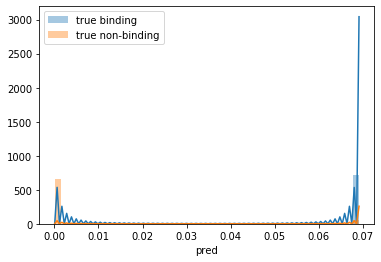

In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
sns.distplot(df_pred['pred'][np.where(df_pred['result']==1)[0]]);
sns.distplot(df_pred['pred'][np.where(df_pred['result']==0)[0]]);
plt.legend(labels=['true binding','true non-binding'])

plt.show()

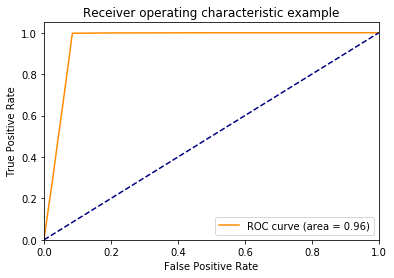

In [27]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
fpr, tpr, thresholds= roc_curve(df_pred['result'],df_pred['pred'])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
          label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [28]:
optimal_threshold=0.069128364
binary_pred=df_pred['pred'].copy()
binary_pred[np.where(binary_pred<=optimal_threshold)[0]]=0
binary_pred[np.where(binary_pred>optimal_threshold)[0]]=1

In [29]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(df_pred['result'], binary_pred).ravel()
# Error rate : 
err_rate = (fp + fn) / (tp + tn + fn + fp)
print("Error rate  : ", err_rate)
# Accuracy : 
acc_ = (tp + tn) / (tp + tn + fn + fp)
print("Accuracy  : ", acc_)
# Sensitivity : 
sens_ = tp / (tp + fn)
print("Sensitivity  : ", sens_)
# Specificity 
sp_ = tn / (tn + fp)
print("Specificity  : ", sp_)
# False positive rate (FPR)
FPR = fp / (tn + fp)
print("False positive rate  : ", FPR)

Error rate  :  0.08141341819146115
Accuracy  :  0.9185865818085388
Sensitivity  :  0.9852981969486824
Specificity  :  0.9166168420765252
False positive rate  :  0.0833831579234749


In [30]:
print( 'positive binding percentage:',sum(output)/len(output))
print('positive binding percentage within events predicted as positive:',tp/(tp+fp))

positive binding percentage: 0.0286793953858393
positive binding percentage within events predicted as positive: 0.25865333268605273
